# 프로젝트 개요
본 프로젝트는 Kaggle의 'Store Sales - Time Series Forecasting' 데이터를 활용하여 매장의 일별 매출 추이를 분석하고, 시계열 데이터의 특성(계절성, 추세 등)을 파악한 뒤 머신러닝 모델을 통해 미래 매출을 예측하는 것을 목표로 한다.

# 변수 설명
## train 데이터프레임:

id: 행을 식별하는 고유 ID.

date: 매출이 기록된 날짜.

store_nbr: 상점 번호.

family: 제품군.

sales: 주어진 날짜에 주어진 상점에서 해당 제품군의 매출액.

onpromotion: 주어진 날짜에 주어진 상점에서 해당 제품군의 프로모션 중인 품목 수.

## stores 데이터프레임:

store_nbr: 상점 번호.

city: 상점이 위치한 도시.

state: 상점이 위치한 주(state).

type: 상점 유형.

cluster: 상점 클러스터 ID.

## oil 데이터프레임:


date: 유가 정보 날짜.

dcoilwtico: 일별 서부 텍사스산 중질유(WTI) 가격.

## 환경 구성: Kaggle API를 연동하여 데이터셋을 직접 다운로드하고 압축을 해제하여 작업 환경을 구축한다.

In [ ]:
from google.colab import files

# kaggle.json 파일을 업로드하세요
files.upload()

# Kaggle 폴더 생성 및 권한 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 데이터셋 다운로드
!kaggle competitions download -c store-sales-time-series-forecasting

# 압축 풀기
!unzip store-sales-time-series-forecasting.zip -d data

# 단계 1: 환경 설정 및 데이터 로드

- 라이브러리 활용: 데이터 처리를 위해 pandas, 시각화를 위해 matplotlib 및 seaborn, 시계열 분석을 위해 statsmodels의 시계열 분해 라이브러리를 사용한다.
- 요구사항:
  1. train.csv는 train라는 변수로 사용
  2. stores.csv는 stores라는 변수로 사용
  3. oil.csv는 oil이라는 변수로 사용

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

train_df = pd.read_csv('./data/raw/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
stores_df = pd.read_csv('./data/raw/store-sales-time-series-forecasting/stores.csv')
oil_df = pd.read_csv('./data/raw/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])

# 단계 2: 데이터 통합 및 전처리
- 분산된 데이터 파일(매출 정보, 매장 정보, 유가 정보)을 '날짜(date)' 또는 '매장 번호(store_nbr)'를 기준으로 병합하여 분석용 통합 데이터프레임을 생성한다.
- 요구사항:
  1. train 변수에 stores와 oil 결합
  2. 유가(dcoilwtico) 결측치는 시계열 흐름에 따라 선형 보간 처리

In [2]:
# 1) oil 결측치: 시계열 흐름에 따라 선형 보간
#    - 날짜를 인덱스로 두고
#    - 전체 날짜 구간(일 단위)로 reindex 후
#    - 요구사항 2: time 기반 선형 보간(interpolate) + 양끝은 ffill/bfill로 마감
# oil_df = oil_df.sort_values("date").set_index("date")
# full_dates = pd.date_range(oil_df.index.min(), oil_df.index.max(), freq="D")
# oil_df = oil_df.reindex(full_dates)

# oil_df["dcoilwtico"] = (
#     oil_df["dcoilwtico"]
#     .interpolate(method="time")   # 날짜 간격 고려한 선형 보간
#     .ffill()                      # 앞쪽 끝 NaN 처리
#     .bfill()                      # 뒤쪽 끝 NaN 처리
# )

oil_df["dcoilwtico"] = oil_df["dcoilwtico"].interpolate(method='linear').fillna(method='bfill')

# oil_df = oil_df.rename_axis("date").reset_index()

# 2) 요구사항 1: train 변수에 stores와 oil 결합
#    - stores: store_nbr 기준
#    - oil: date 기준
train_df = train_df.merge(stores_df, on="store_nbr", how="left")
train_df = train_df.merge(oil_df, on="date", how="left")

train_df.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_7680\3541696348.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_df["dcoilwtico"] = oil_df["dcoilwtico"].interpolate(method='linear').fillna(method='bfill')


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14


# 단계 3: 탐색적 데이터 분석 (EDA) 및 시각화
- 전체 추이 분석: 일별 매출 합계를 계산하고 시각화하여 전반적인 매출 흐름을 파악한다.

- 시계열 분해: seasonal_decompose를 사용하여 매출 데이터를 가법 모델(Additive Model) 기준으로 추세(Trend), 계절성(Seasonal), 잔차(Resid)로 분해하여 분석한다.

- 패턴 확인: 요일별 매출 분포를 박스플롯(Boxplot)으로 시각화하여 특정 요일에 매출이 집중되는지(계절성 패턴) 확인한다.

- 요구사항:
  1. 일별합계(daily_sales 변수 사용)을 통해 전체 매출 추이를 확인한다.
  2. result변수 안에 시계열 분해에 대한 값을 작성하고 계절성(1년)을 확인하다. (model='additive')
  3. 시각화를 통해 result의 패턴을 확인한다. (Observed, Trend, Seasonal, Resid)
  4. 시각화를 통해 요일별 매출 특성을 확인한다. (boxplot 사용)

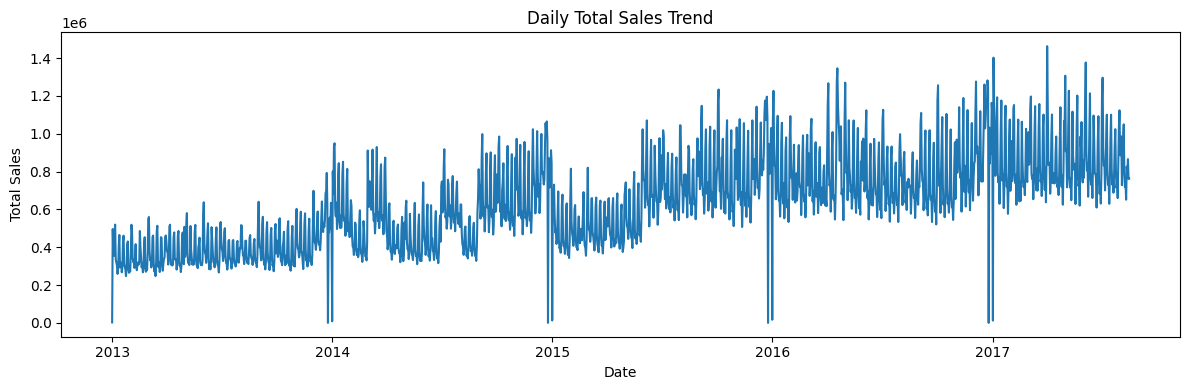

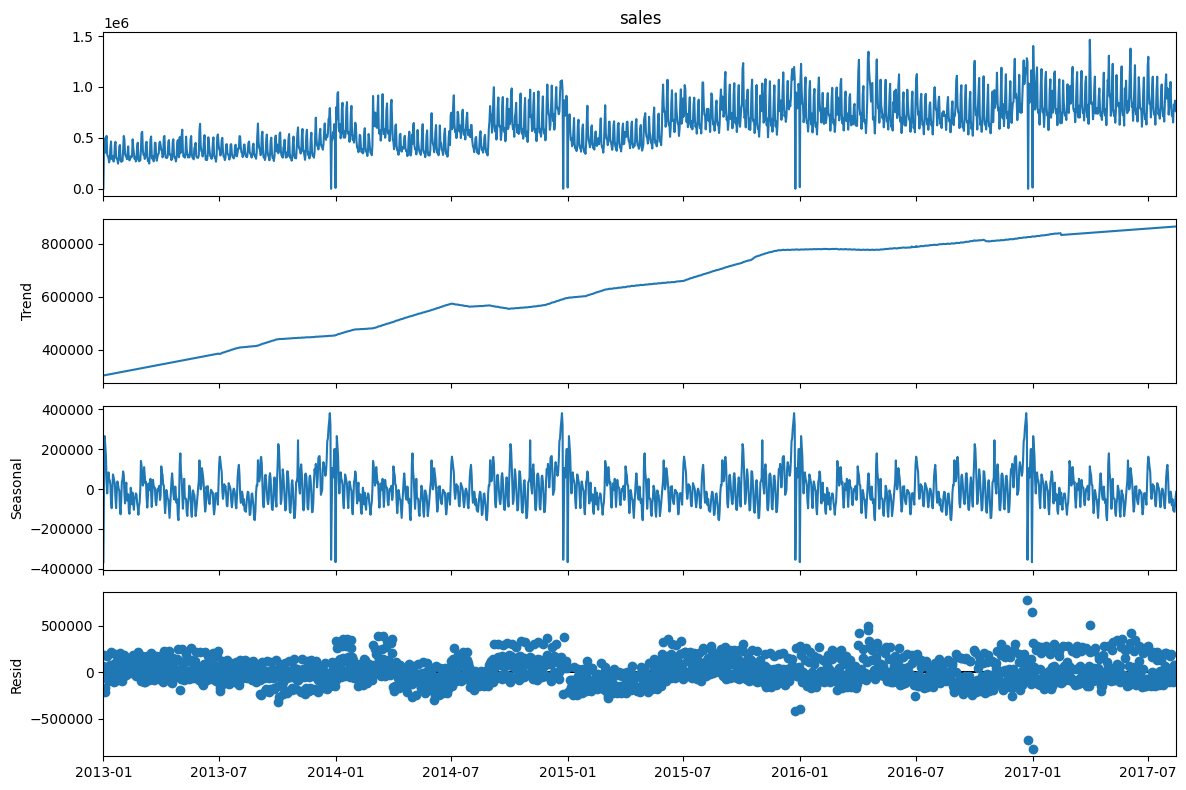

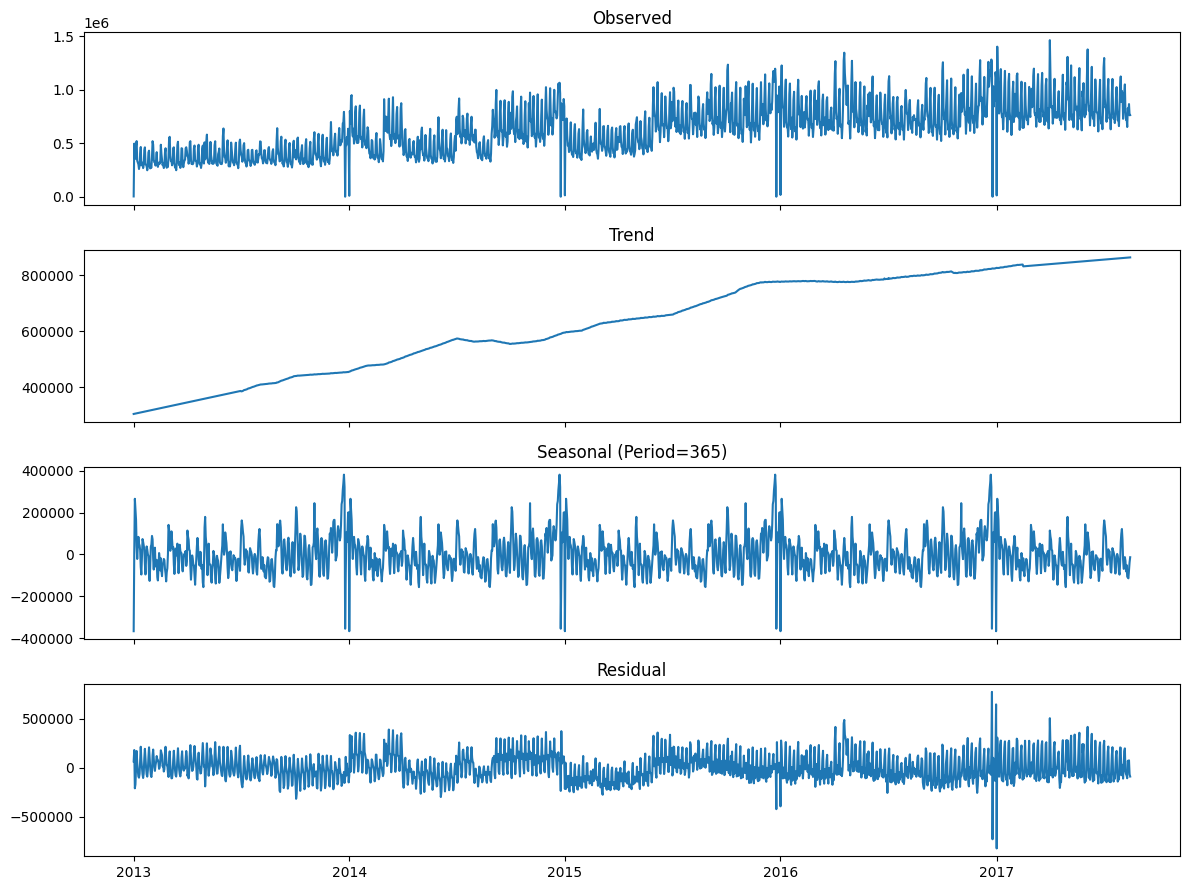

<Figure size 1000x400 with 0 Axes>

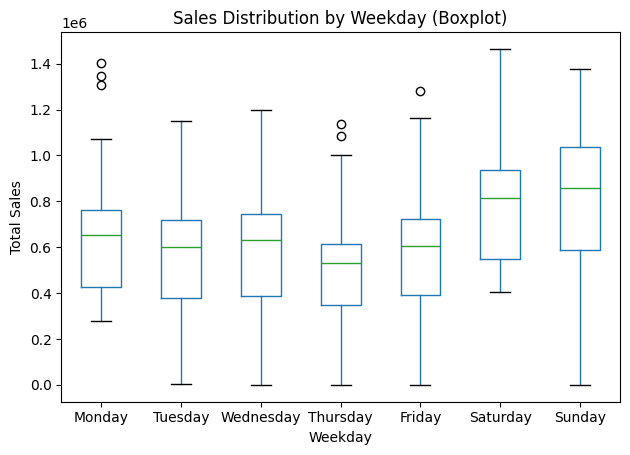

In [3]:
# train 데이터프레임이 이미 존재한다고 가정 (단계2에서 만든 train)
# 날짜 타입 보장
train_df["date"] = pd.to_datetime(train_df["date"])

# =========================
# 1) 일별 매출 합계 (daily_sales)
# =========================
# ※ sales 컬럼명이 다르면 여기만 바꿔줘!
daily_sales = (
    train_df.groupby("date")["sales"]
    .sum()
    .sort_index()
)

# 날짜 연속성 맞추기 (일 단위 시계열)
# - 분해/그래프 안정성 위해 전체 날짜로 reindex
full_dates = pd.date_range(daily_sales.index.min(), daily_sales.index.max(), freq="D")
daily_sales = daily_sales.reindex(full_dates)

# 결측 처리: 매출 데이터에서 날짜가 비는 건 보통 "기록 없음" or "0"으로 처리하는 경우 많아서 0으로 채움
# (과제 요구사항엔 oil만 보간이지만, decompose 하려면 NaN 없어야 해서 필요)
daily_sales = daily_sales.fillna(0)
daily_sales.index.name = "date"

# =========================
# 요구사항 1) 전체 매출 추이 시각화
# =========================
plt.figure(figsize=(12, 4))
plt.plot(daily_sales.index, daily_sales.values)
plt.title("Daily Total Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()


# =========================
# 2) 시계열 분해 (Additive / 1년 seasonality)
# =========================
# 요구사항 2) result 변수에 저장 + 1년(365일) 주기
# ※ 데이터가 최소 2년 가까이 있어야 365 분해가 안정적임(짧으면 결과가 흔들릴 수 있음)
result = seasonal_decompose(
    daily_sales,
    model="additive",
    period=365,               # 1년 주기(일별 데이터 기준)
    extrapolate_trend="freq"  # trend 끝부분 NaN 줄이기
)

# =========================
# 요구사항 3) Observed/Trend/Seasonal/Resid 패턴 시각화
# =========================
# 방법 A: statsmodels 기본 plot
result.plot()
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()

# (원하면) 방법 B: 4개를 더 깔끔하게 직접 배치
fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)

axes[0].plot(result.observed)
axes[0].set_title("Observed")

axes[1].plot(result.trend)
axes[1].set_title("Trend")

axes[2].plot(result.seasonal)
axes[2].set_title("Seasonal (Period=365)")

axes[3].plot(result.resid)
axes[3].set_title("Residual")

plt.tight_layout()
plt.show()


# =========================
# 3) 요일별 매출 분포 (boxplot)
# =========================
# 일별합계를 데이터프레임으로 바꿔 요일 컬럼 붙임
daily_df = daily_sales.reset_index()
daily_df.columns = ["date", "total_sales"]

# 요일 추출 (월=0 ~ 일=6) + 이름 매핑
daily_df["weekday"] = daily_df["date"].dt.day_name()

# 요일 순서 고정(보기 좋게)
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_df["weekday"] = pd.Categorical(daily_df["weekday"], categories=weekday_order, ordered=True)

# 요구사항 4) boxplot 시각화
plt.figure(figsize=(10, 4))
daily_df.boxplot(column="total_sales", by="weekday", grid=False)
plt.title("Sales Distribution by Weekday (Boxplot)")
plt.suptitle("")  # 판다스 boxplot 기본 suptitle 제거
plt.xlabel("Weekday")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()


In [ ]:
!pip install pmdarima

# 단계 4: 통계적 시계열 모델링 (ARIMA)
- 라이브러리 활용: pmdarima 라이브러리의 auto_arima를 사용하여 최적의 통계 모델 파라미터를 자동으로 추출한다.
- 요구사항:
  1. 계절성 설정: 데이터의 주간 패턴을 반영하기 위해 주기(m)를 7로 설정하고, seasonal=True 옵션을 부여한다.
  2. 모델 요약 분석: summary() 함수를 통해 산출된 AIC, BIC 값을 확인하여 모델의 적합도를 평가한다.
  3. 미래 예측: 학습된 모델을 바탕으로 향후 15일간의 매출을 예측한다.

In [8]:
from pmdarima import auto_arima

# 학습 데이터 추출
# ts_data = daily_sales('date')['sales']
ts_data = daily_sales.astype(float).asfreq("D").fillna(0)

# 최적의 ARIMA 파라미터 탐색
arima_model = auto_arima(ts_data, seasonal=True, m=7, suppress_warnings=True)
print(arima_model.summary())

# 예측
arima_forecast = arima_model.predict(n_periods=15)

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1688
Model:             SARIMAX(4, 1, 2)x(1, 0, 2, 7)   Log Likelihood              -21937.661
Date:                           Thu, 12 Feb 2026   AIC                          43897.323
Time:                                   11:44:41   BIC                          43957.061
Sample:                               01-01-2013   HQIC                         43919.446
                                    - 08-15-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1133.2075    363.155      3.120      0.002     421.437    1844.978
ar.L1         -0.7590      0.058    -13.195

In [ ]:
from pmdarima import auto_arima

# daily_sales: pd.Series (index=date, values=total_sales)
# 안전하게 결측 제거/정리
y = daily_sales.astype(float).copy()
y = y.asfreq("D")              # 일 단위 주기 고정
y = y.fillna(0)                # 결측이 있으면 분해/ARIMA에서 터질 수 있어서 정리

# =========================
# 1) 계절성 설정: 주간 패턴(m=7), seasonal=True
# =========================
model = auto_arima(
    y,
    seasonal=True,
    m=7,                        # 주간 seasonality
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=None, D=None,             # 차분 자동 추정
    trace=True,                 # 탐색 로그 보고 싶으면 True
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True               # 속도/안정성 좋음
)

# =========================
# 2) 모델 요약: AIC, BIC 확인
# =========================
print(model.summary())  # 여기 안에 AIC, BIC 뜸

# =========================
# 3) 미래 15일 예측
# =========================
n_periods = 15
prophet_forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

future_index = pd.date_range(
    start=y.index[-1] + pd.Timedelta(days=1),
    periods=n_periods,
    freq="D"
)

forecast_series = pd.Series(prophet_forecast, index=future_index, name="forecast")
conf_df = pd.DataFrame(conf_int, index=future_index, columns=["lower", "upper"])

# 예측 결과 확인
display(forecast_series.head())
display(conf_df.head())

# (시각화) 과거 + 예측 + 신뢰구간
plt.figure(figsize=(12, 4))
plt.plot(y.index, y.values, label="Observed")
plt.plot(forecast_series.index, forecast_series.values, label="Forecast (15 days)")
plt.fill_between(conf_df.index, conf_df["lower"], conf_df["upper"], alpha=0.2, label="Confidence Interval")
plt.title("ARIMA Forecast (Seasonal m=7)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.tight_layout()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=45466.149, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=44664.083, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=44846.762, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=45464.160, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=45441.043, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=44634.106, Time=0.26 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=44532.831, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=44907.597, Time=0.09 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=44791.329, Time=0.21 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=44676.122, Time=0.26 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=44363.091, Time=0.42 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   :

KeyboardInterrupt: 

# 단계 5: ARIMA 모델링을 사용하여 시각화
- 예측한 모델링을 사용하여, 미래를 예측(15일)
- 요구사항:
  1. 미래 날짜 인덱스 생성:
    - ts_data의 마지막 날짜를 기준으로 바로 다음 날부터 시작하는 15일간의 날짜 범위를 생성하세요.
    - 변수명: forecast_index (힌트: pd.date_range 활용)
  2. 예측 실행:
    - arima_model의 예측 함수를 호출하여 15일치 예측값과 **신뢰구간(Confidence Interval)**을 동시에 추출하세요.
    - 변수명: forecast_values (예측값), conf_int (신뢰구간)
    - 옵션: return_conf_int=True를 반드시 설정하세요.
  3. 시각화 구성:
    - 과거 데이터: 전체 데이터가 아닌 최근 90일치(tail(90))만 시각화하여 예측 지점이 잘 보이게 하세요. (검정색 선)
    - 예측 데이터: forecast_index를 축으로 예측값을 붉은색 점 표식(marker='o')과 함께 그리세요.
    - 신뢰구간 표시: plt.fill_between을 사용하여 예측 하한선(conf_int[:, 0])과 상한선(conf_int[:, 1]) 사이를 옅은 붉은색(alpha=0.15)으로 채우세요.

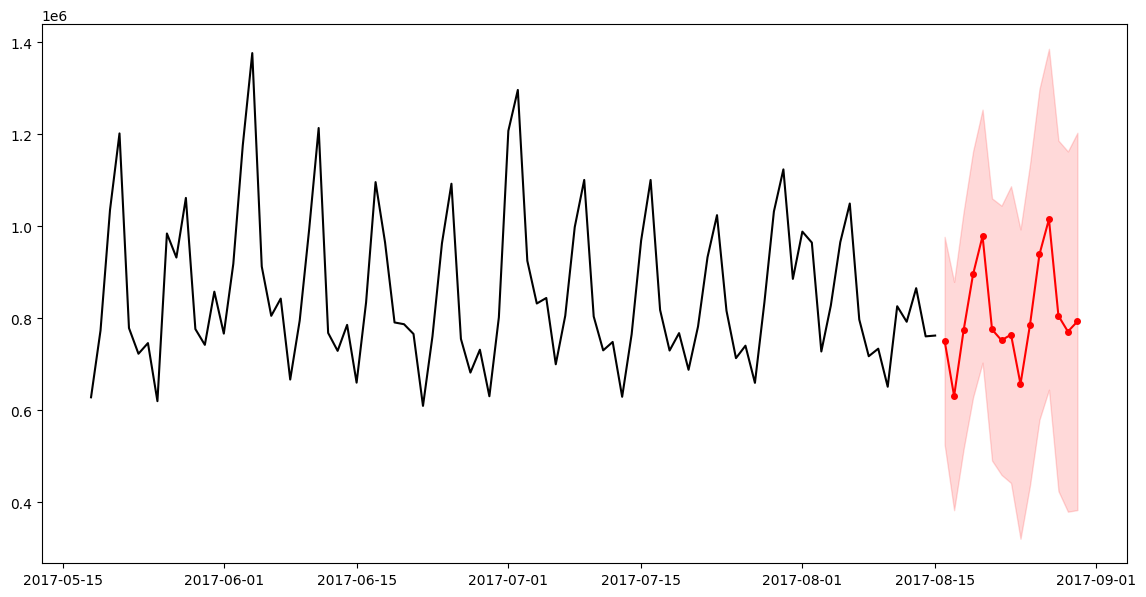

In [12]:
last_date = ts_data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=15)

forecast_value, conf_int = arima_model.predict(n_periods=15, return_conf_int=True)

plt.figure(figsize=(14, 7))

plt.plot(ts_data.tail(90), label='Actual Sales', color='black', linewidth=1.5)

plt.plot(forecast_index, forecast_value, label='ARIMA Foreecast', color='red', marker='o', markersize=4)

plt.fill_between(
    forecast_index,
    conf_int[:, 0],
    conf_int[:, 1],
    color='red',
    alpha=0.15
)

# 단계 6: Meta Prophet 모델을 활용한 예측 및 시각화
- 데이터 형식 변환: Prophet 모델은 고정된 컬럼명을 요구한다. 날짜 컬럼을 ds로, 매출 컬럼을 y로 변경하여 df_prophet 변수에 저장한다.

- 모델 설정: 유연한 추세 변화 포착을 위해 changepoint_prior_scale 매개변수를 0.05로 설정하여 모델을 생성한다.

- 미래 프레임워크 생성: make_future_dataframe 메소드를 사용하여 기존 학습 데이터 끝에서부터 향후 15일간의 빈 데이터프레임을 생성한다.

- 예측 및 시각화: 생성된 프레임워크에 대해 예측(predict)을 수행하고, 내장 함수인 plot()을 사용하여 예측값과 신뢰구간을 시각화한다.

- 요구사항:
  1. 데이터 준비:
    - daily_sales 데이터프레임의 'date' 컬럼은 **'ds'**로, 'sales' 컬럼은 **'y'**로 이름을 변경하세요.
    - 변수명: df_prophet

  2. 모델 선언 및 학습:
    - Prophet 객체를 생성할 때 추세 유연성 파라미터(changepoint_prior_scale)를 0.05로 지정하세요.
    - 변수명: m

  3. 미래 날짜 생성 및 예측:
    - 학습 데이터 이후 15일치를 예측할 수 있는 데이터프레임을 생성하세요.
    - 변수명: future (날짜 프레임), forecast (예측 결과 데이터프레임)

  4. 시각화:
    - m.plot() 함수를 호출하여 실제값, 예측값, 신뢰구간이 포함된 그래프를 출력하세요.

14:33:35 - cmdstanpy - INFO - Chain [1] start processing
14:33:35 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Prophet Sales Forecast')

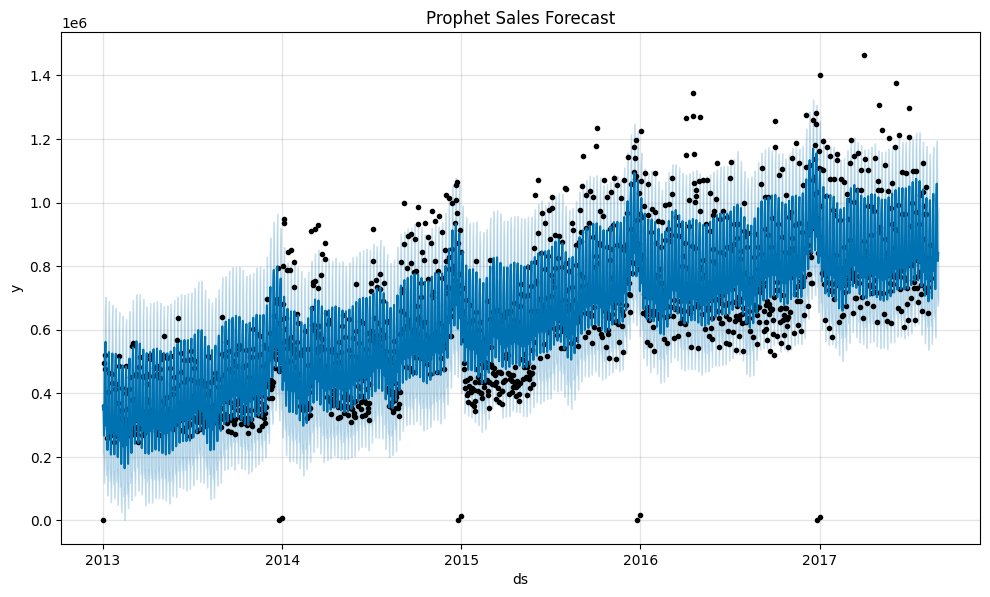

In [18]:
from prophet import Prophet

s = daily_sales.reset_index()
df_prophet = s.rename(columns={'date' : 'ds', 'sales' : 'y'})

m = Prophet(changepoint_prior_scale=0.05)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=15)
prophet_forecast = m.predict(future)

m.plot(prophet_forecast)
plt.title('Prophet Sales Forecast')

# 단계 7: Prophet의 예측 결과와 ARIMA의 예측 결과를 하나의 차트에 표현
- 비교 기준 설정: 동일한 15일의 미래 기간(forecast_index)에 대해 두 모델의 예측값을 병렬로 추출한다.

- 데이터 추출:

  - ARIMA: arima_model.predict(n_periods=15)를 통해 직접 예측값을 얻는다.

  - Prophet: 전체 예측 결과(forecast) 중 마지막 15개 행의 'yhat' 컬럼만 추출하여 배열로 저장한다.

- 시각화 가독성: 과거 데이터는 최근 60일치만 표시하여 예측 구간이 돋보이게 한다.

- 패턴 분석 (심화): axvspan을 사용하여 그래프 상에 주말(토, 일) 영역을 음영 처리하고, 각 모델이 주말의 매출 상승/하락 패턴을 어떻게 다르게 예측하는지 확인한다.

- 요구사항:
  1. 미래 날짜 생성: forecast_index 변수에 향후 15일간의 pd.date_range를 생성하세요.

  2. ARIMA 결과 준비: arima_model로부터 15일치 예측값을 추출하여 arima_pred에 저장하세요.

  3. Prophet 결과 준비: Prophet 예측 결과인 prophet_forecast 데이터프레임에서 마지막 15일의 예측값(yhat)을 추출하여 prophet_pred에 저장하세요.

  4. 시각화 설정:

  - 실제 데이터: ts_data.tail(60) (검정색 실선, 투명도 0.6)

  - ARIMA: 붉은색 점선(--)과 원형 마커(o)

  - Prophet: 파란색 점선(--)과 사각형 마커(s)

  5. 주말 강조: forecast_index를 순회하며 토요일(5)과 일요일(6)인 지점에 plt.axvspan을 적용하세요.

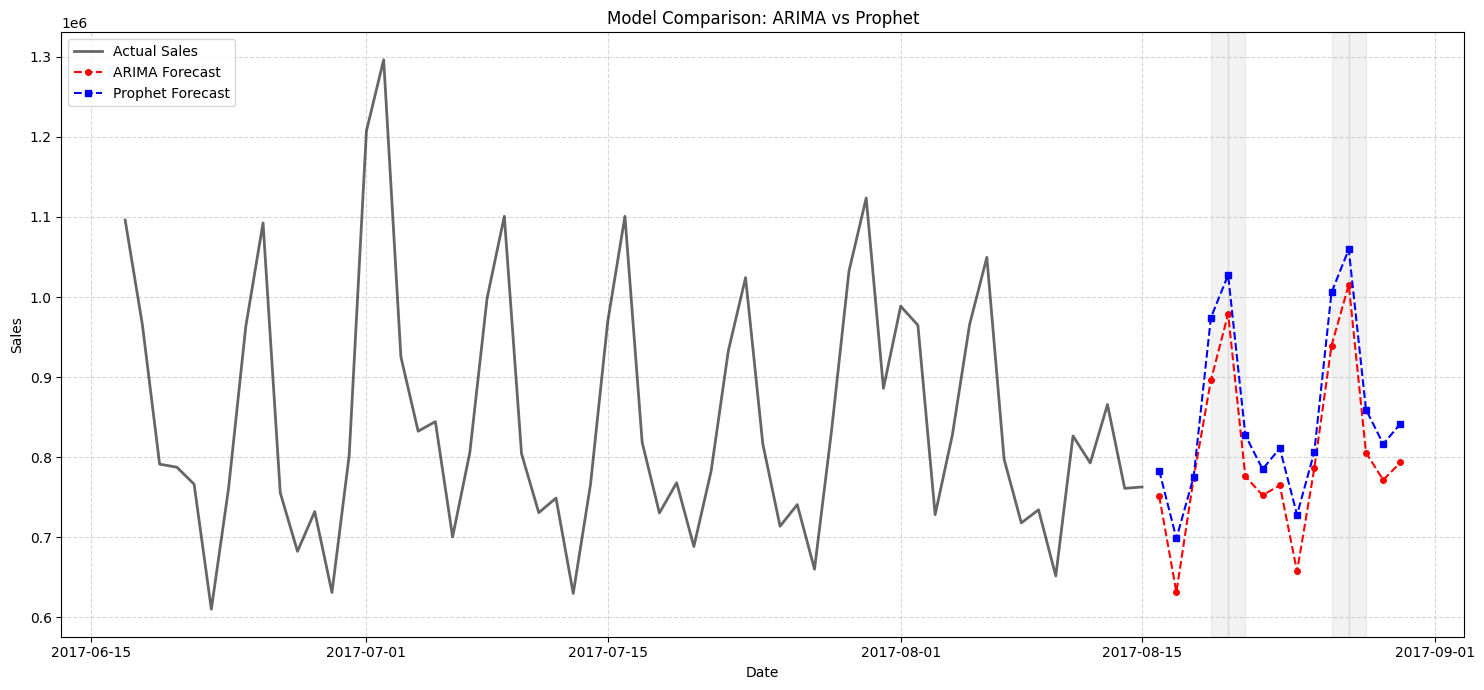

In [19]:
# 0) 안전장치: ts_data 인덱스가 datetime인지 확인
ts_data.index = pd.to_datetime(ts_data.index)

# 1) 미래 날짜 생성 (15일) - 요구사항 1
last_date = ts_data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=15, freq="D")

# 2) ARIMA 결과 준비 - 요구사항 2
arima_pred = arima_model.predict(n_periods=15)

# 3) Prophet 결과 준비 - 요구사항 3
# prophet_forecast(=m.predict(future))가 이미 있다면 마지막 15일 yhat만 추출
# (변수명이 forecast라면 prophet_forecast = forecast 로 바꿔 쓰면 됨)
prophet_pred = prophet_forecast.tail(15)["yhat"].values

# 4) 시각화 - 요구사항 4
plt.figure(figsize=(15, 7))

# 실제 데이터: 최근 60일 (검정 실선, alpha 0.6)
plt.plot(ts_data.tail(60), label="Actual Sales", color="black", alpha=0.6, linewidth=2)

# ARIMA: 붉은색 점선(--) + 원형 마커(o)
plt.plot(forecast_index, arima_pred, label="ARIMA Forecast", color="red",
         linestyle="--", marker="o", markersize=4)

# Prophet: 파란색 점선(--) + 사각형 마커(s)
plt.plot(forecast_index, prophet_pred, label="Prophet Forecast", color="blue",
         linestyle="--", marker="s", markersize=4)

# 5) 주말 강조 - 요구사항 5 (토=5, 일=6)
for d in forecast_index:
    if d.dayofweek >= 5:
        plt.axvspan(d, d + pd.Timedelta(days=1), color="gray", alpha=0.1)

# 그래프 서식
plt.title("Model Comparison: ARIMA vs Prophet")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()